In [26]:
# Data Processing
# Ethan L. Edmunds, Jan 2025

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit

In [27]:
# Load the data into a pandas Dataframe
file_path = 'Full_ICY_Durham_data'
df = pd.read_csv(file_path)

unique_tesla = df['Tesla'].unique()
unique_angle = df['Angle'].unique()

print(df.head())

   Tesla  Angle   Current   Voltage   Time
0    0.0    0.0 -0.018331  0.998907  0.046
1    0.0    0.0 -0.019037  0.998276  0.093
2    0.0    0.0 -0.018184  0.991219  0.138
3    0.0    0.0 -0.018356  0.985850  0.185
4    0.0    0.0 -0.018423  0.979989  0.230


In [28]:
# Define the distances in mm (converting to metres)
distance = 12.7/1000

# Voltage correction
for tesla in unique_tesla:
    for angle in unique_angle:

        df_filtered = df[(df['Tesla'] == tesla) & (df['Angle'] == angle)]  # Create a filtered dataframe based on unique value of tesla and angle

        if not df_filtered.empty:

            max_current = df_filtered['Current'].max()

            df_filtered_linear = df_filtered[(df_filtered['Current'] < max_current * 0.4)]  # Ensure you filter on df_filtered, not df

            # Apply a linear fit to the filtered data
            coefficients = np.polyfit(df_filtered_linear['Current'], df_filtered_linear['Voltage'], 1)

            # Calculate the fitted voltages using the polynomial fit
            background_voltage = np.polyval(coefficients, df_filtered['Current'])

            # Subtract the fitted voltages from the original 'Voltage' column to get the 'Fixed_Voltage'
            df.loc[(df['Tesla'] == tesla) & (df['Angle'] == angle), 'Fixed_Voltage'] = df_filtered['Voltage'] - background_voltage

# Calculate Electric Field for both distances (E) for both distances
df['Electric Field'] = df['Fixed_Voltage']/distance

# Identify the power law
def power_law(I, I_c, n):

    I = np.abs(I) + 1e-9

    E_c = 100 # Fixed J_c to be assumed value
    return E_c * (I / I_c) ** n

# Finding n exponent for each curve
for tesla in unique_tesla:
    for angle in unique_angle:

        # print(f"Analysis for Tesla: {tesla} at Angle: {angle}")

        df_filtered = df[(df['Tesla'] == tesla) & (df['Angle'] == angle)]  # Create a filtered dataframe based on unique value of tesla and angle

        if not df_filtered.empty:

            # print(df_filtered.head())

            # Extract current density and electric field from the DataFrame
            I_data = df_filtered['Current']  # Current Density (A/m²)
            E_data = df_filtered['Fixed_Voltage']  # Fixed Voltage is used as the Electric Field

            # Check if the data looks reasonable (no NaNs or Inf)
            if np.any(np.isnan(I_data)) or np.any(np.isnan(E_data)) or np.any(np.isinf(I_data)) or np.any(np.isinf(E_data)):
                print("Warning: NaN or infinite values in the data.")
                continue

            popt, pcov = curve_fit(power_law, I_data, E_data)

            E_c_fitted, n_fitted = popt

            df.loc[(df['Tesla'] == tesla) & (df['Angle'] == angle), 'Critical_Current'] = df_filtered['Current'] * (E_c_fitted/df['Electric Field'])**(1/n_fitted)

print(df.head())

   Tesla  Angle   Current   Voltage   Time  Fixed_Voltage  Electric Field  \
0    0.0    0.0 -0.018331  0.998907  0.046       0.301514       23.741247   
1    0.0    0.0 -0.019037  0.998276  0.093       0.300918       23.694361   
2    0.0    0.0 -0.018184  0.991219  0.138       0.293818       23.135310   
3    0.0    0.0 -0.018356  0.985850  0.185       0.288458       22.713236   
4    0.0    0.0 -0.018423  0.979989  0.230       0.282600       22.252006   

   Critical_Current  
0         -0.019106  
1         -0.019845  
2         -0.018994  
3         -0.019204  
4         -0.019307  


C:\Users\Ethan\AppData\Local\Temp\ipykernel_19568\998274809.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(tesla_values) * len(angle_values))  # Use 'tab20' colormap


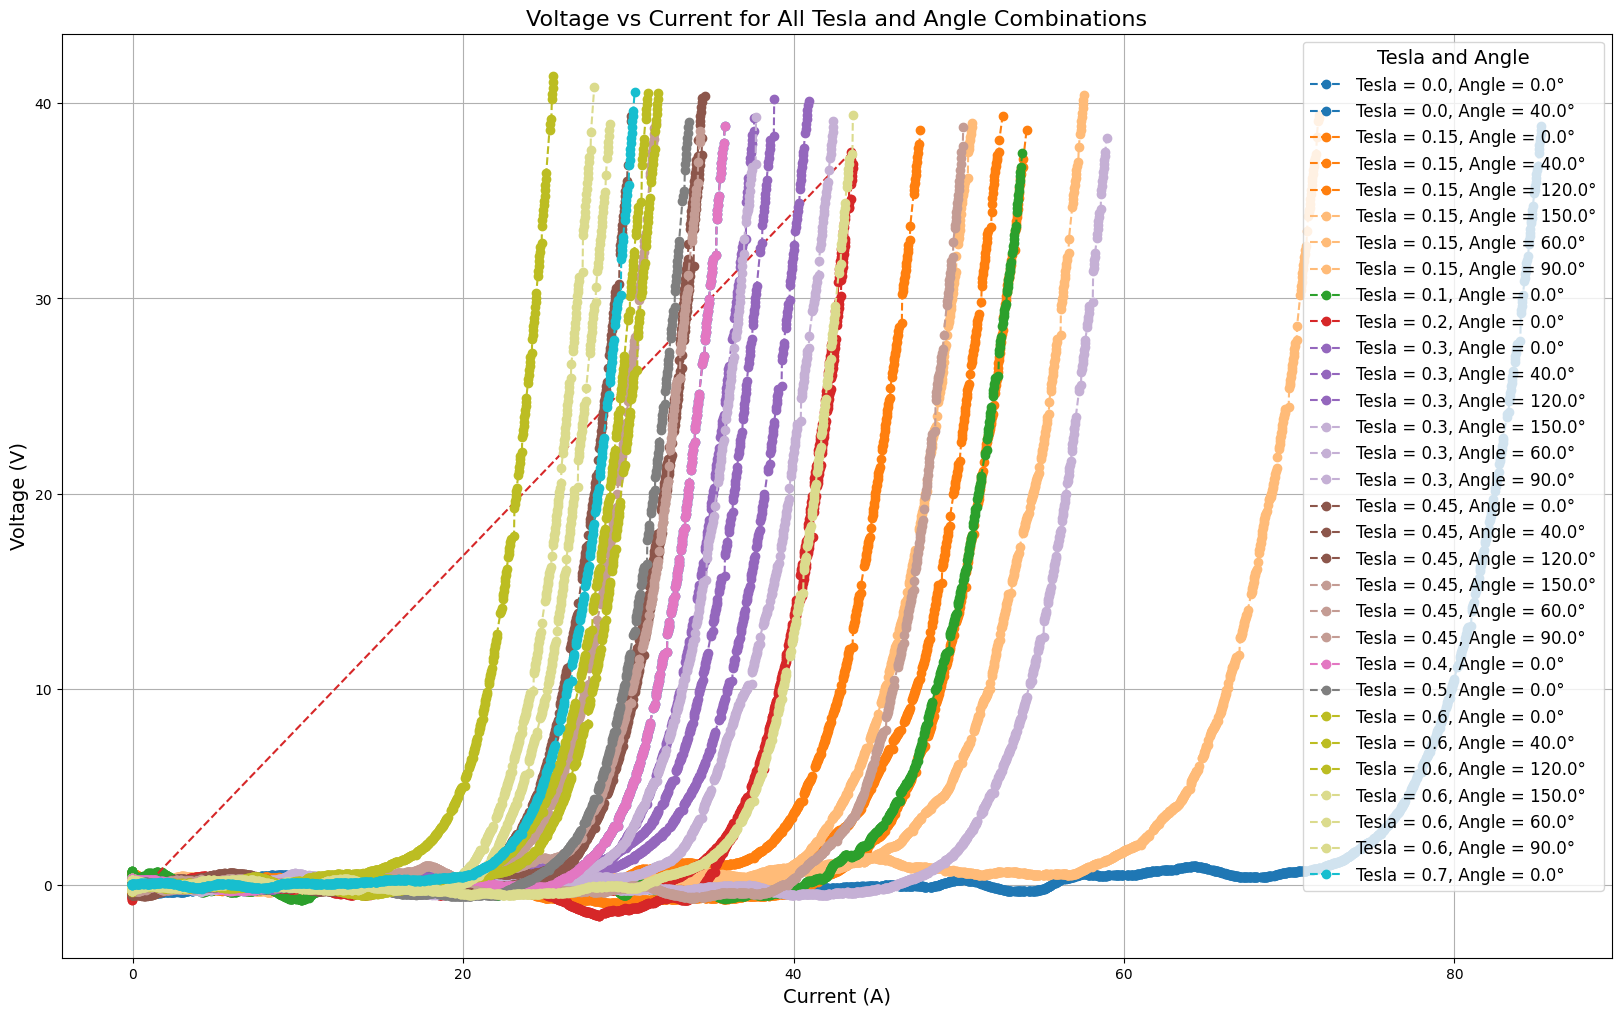

In [29]:
# Plotting some data by field_angle and tesla
def plot_voltage_current(df, tesla_values, angle_values):

    if isinstance(tesla_values, (float, int)):  # Check if it's a single value
        tesla_values = [tesla_values]  # Convert to a list
    if isinstance(angle_values, (float, int)):  # Check if it's a single value
        angle_values = [angle_values]  # Convert to a list

    plt.figure(figsize=(20, 12))  # Create a single plot for all data
    
    # Define a colormap for distinguishing the combinations
    cmap = cm.get_cmap('tab20', len(tesla_values) * len(angle_values))  # Use 'tab20' colormap

    # Loop over each Tesla and Angle combination to plot the data
    for idx, (tesla, angle) in enumerate([(tesla, angle) for tesla in tesla_values for angle in angle_values]):
        # Filter the DataFrame for the current Tesla and Angle values
        filtered_data = df[(df['Tesla'] == tesla) & (df['Angle'] == angle)]

        # If there is data to plot, plot it on the same graph
        if not filtered_data.empty:
            color = cmap(idx)  # Get a color from the colormap
            label = f'Tesla = {tesla}, Angle = {angle}°'  # Label for the legend
            plt.plot(filtered_data['Current'], filtered_data['Fixed_Voltage'], label=label, color=color, marker='o', linestyle='--')

    # Add labels and legend
    plt.xlabel("Current (A)", fontsize=14)
    plt.ylabel("Voltage (V)", fontsize=14)
    plt.title("Voltage vs Current for All Tesla and Angle Combinations", fontsize=16)
    plt.legend(title="Tesla and Angle", fontsize=12, title_fontsize=14)
    plt.grid(True)
    plt.show()

plot_voltage_current(df, unique_tesla, unique_angle)
